In [1]:
%load_ext autoreload
%autoreload 2

# Managing samples

As STIsim models are usually stochastic, for a single scenario it is often desirable to run the model multiple times with different random seeds. The role of the `Samples` class is to facilitate working with large numbers of simulations and scenarios, to ease:

- Loading large result sets
- Filtering/selecting simulation runs
- Plotting individual simulations and aggregate results
- Slicing result sets to compare scenarios

Essentially, if we think of the processed results of a model run as being

- A collection of scalar outputs (e.g., cumulative infections, total deaths)
- A dataframe of time-varying outputs (e.g., new diagnoses per day, number of people on treatment each day)

then the classes `Dataset` and `Samples` manage collections of these results. In particular, the `Samples` class manages different random samples of the same parameters, and the `Dataset` class manages a collection of `Samples`. 

<div class="alert alert-block alert-info">    
These classes are particularly designed to facilitate working with tens of thousands of simulation runs, where other approaches such as those based on the `MultiSim` class may not be feasible.
</div>


In [2]:
import stisim as ss
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import sciris as sc

STIsim 0.0.8 (2023-10-04) — © 2023 by IDM


## Obtaining simulation output

To demonstrate usage of this class, we will first consider constructing the kinds of output that the `Samples` class stores. We begin by running a basic simulation using the SIR model:

In [3]:
ppl = ss.People(10000)
ppl.networks = ss.ndict(ss.RandomNetwork(n_contacts=ss.poisson(5)))
sir = ss.SIR()
sim = ss.Sim(people=ppl, diseases=sir, rand_seed=0)
sim.run();

Initializing sim (warning: not resetting sim.people) with 10000 agents
  Running 1995.0 ( 0/36) (1.43 s)  ———————————————————— 3%
  Running 2005.0 (10/36) (2.42 s)  ••••••—————————————— 31%
  Running 2015.0 (20/36) (2.45 s)  •••••••••••————————— 58%
  Running 2025.0 (30/36) (2.48 s)  •••••••••••••••••——— 86%


### Dataframe output

A `Sim` instance is (in general) too large and complex to efficiently store on disk - the file size and loading time make it prohibitive to work with tens of thousands of simulations. Therefore, rather than storing entire `Sim` instances, we instead store dataframes containing just the simulation results and any other pre-processed calculated quantities. There are broadly speaking two types of outputs

- Scalar outputs at each timepoint (e.g., daily new cases)
- Scalar outputs for each simulation (e.g., total number of deaths)

These outputs can each be produced from a `Sim` - the former has a tabular structure, and the latter has a dictionary structure (which can later be assembled into a table where the rows correspond to each simulation). The `export_df` method is a quick way to obtain a dataframe with the appropriate structure retaining all results from the `Sim`.


<div class="alert alert-block alert-info">    
In real-world use, it is often helpful to write your own function to extract a dataframe of simulation outputs, because typically some of the outputs need to be extracted from custom Analyzers.
</div>


In [4]:
sim.export_df()

,n_alive,new_deaths,sir.n_susceptible,sir.n_infected,sir.n_recovered,sir.prevalence,sir.new_infections
t,,,,,,,
1995.0,10000,0,9983,17,0,0.001700,17
1996.0,10000,0,9906,94,0,0.009400,78
1997.0,10000,0,9442,558,0,0.055800,478
1998.0,10000,0,7104,2895,1,0.289500,2702
1999.0,9999,1,1752,8242,5,0.824282,10264
2000.0,9996,3,78,9896,22,0.989996,7196
2001.0,9976,20,1,9830,145,0.985365,391
2002.0,9817,159,1,9174,642,0.934501,0
2003.0,9353,464,0,7270,2083,0.777291,2


### Scalar/summary outputs

We can also consider extracting a summary dictionary of scalar values. For example:

In [5]:
summary = {}
summary['seed'] = sim.pars['rand_seed']
summary['p_death']: sim.diseases[0].pars.p_death
summary['cum_infections'] = sum(sim.results.sir.new_infections)
summary['cum_deaths'] = sum(sim.results.new_deaths)
summary

{'seed': 0, 'cum_infections': 21128, 'cum_deaths': 3394}

<div class="alert alert-warning alert-info">    
Notice how in the example above, the summary contains both simulation inputs (seed, probability of death) as well as simulation outputs (total infections, total deaths). The simulation summary should contain sufficient information about the simulation inputs to identify the simulation. The seed should generally be present. The other inputs normally correspond to variables that scenarios are being run over. In this example, we will run scenarios comparing simulations with different probabilities of death. Therefore, we need to include the death probability in the simulation summary. 
</div>

### Running the model

For usage at scale, the steps of creating a simulation, running it and producing these outputs are usually encapsulated in functions

In [6]:
def get_sim(seed, p_death):
    ppl = ss.People(10000)
    ppl.networks = ss.ndict(ss.RandomNetwork(n_contacts=ss.poisson(5)))
    sir = ss.SIR(pars={'p_death':p_death})
    sim = ss.Sim(people=ppl, diseases=sir, rand_seed=seed)
    sim.initialize(verbose=0)
    return sim
    
def run_sim(seed, p_death):
    sim = get_sim(seed, p_death)
    sim.run(verbose=0)
    df = sim.export_df()
    
    summary = {}
    summary['seed'] = sim.pars['rand_seed']
    summary['p_death']= sim.diseases[0].pars.p_death
    summary['cum_infections'] = sum(sim.results.sir.new_infections)
    summary['cum_deaths'] = sum(sim.results.new_deaths)
    
    return df, summary

<div class="alert alert-success">    
The functions above could be combined into a single function. However, in real world usage it is often convenient to be able to construct a simulation independently of running it (e.g., for diagnostic purposes or to allow running the sim in a range of different ways). The suggested structure above, with a <code>get_sim()</code> function and a <code>run_sim()</code> function are recommended as standard practice.
</div>

Now running a simulation for a given beta/seed value and returning the processed outputs can be done in a single step

In [7]:
# Scalar output
df, summary = run_sim(0, 0.2);
summary

{'seed': 0, 'p_death': 0.2, 'cum_infections': 21095, 'cum_deaths': 3433}

We can produce all of the samples associated with a scenario by iterating over the input seed values. This is being done in a basic loop here, but could be done in more sophistical ways to leverage parallel computing (e.g., with `sc.parallelize` for single host parallelization, or with `celery` for distributed computation). 

In [8]:
# Run a collection of sims
n = 100
seeds = np.arange(n)
outputs = [run_sim(seed, 0.2) for seed in seeds]

## Saving and loading the samples

We have now produced simulation outputs (dataframes and summary statistics) for 100 simulation runs. The `outputs` here are a list of tuples, containing the dataframe and dictionary outputs for each sample. This list can be passed to the `cvv.Samples` class to produce a single compressed file on disk

In [9]:
resultsdir = Path('results')
resultsdir.mkdir(exist_ok=True, parents=True)
ss.Samples.new(resultsdir, outputs, identifiers=["p_death"])
list(resultsdir.iterdir())

[WindowsPath('results/0.0-1.zip'),
 WindowsPath('results/0.0-2.zip'),
 WindowsPath('results/0.0-3.zip'),
 WindowsPath('results/0.2.zip'),
 WindowsPath('results/0.25-1.zip'),
 WindowsPath('results/0.25-2.zip'),
 WindowsPath('results/0.25-3.zip'),
 WindowsPath('results/0.5-1.zip'),
 WindowsPath('results/0.5-2.zip'),
 WindowsPath('results/0.5-3.zip'),
 WindowsPath('results/0.75-1.zip'),
 WindowsPath('results/0.75-2.zip'),
 WindowsPath('results/0.75-3.zip')]

Notice that a list of `identifiers` should be passed to the `Samples` constructor. This is a list of keys in the simulation summary dictionaries that identifies the scenario. These would be model inputs rather than model outputs, and they should be the same for all of the outputs passed into the `Samples` object. If no file name is explicitly provided, the file will automatically be assigned a name based on the identifiers.

<div class="alert alert-success">    
The <code>Samples</code> file internally contains metadata recording the identifiers. When <code>Samples</code> are accessed using the <code>Dataset</code> class, they can be accessed via the internal metadata. Therefore for a typical workflow, the file name largely doesn't matter, and it usually doesn't need to be manually specified.
</div>

The saved file can be loaded and accessed via the `Samples` class. **Importantly, individual files can be extracted from a `.zip` file without decompressing the entire archive**. This means that loading the summary dataframe and using it to selectively load the full outputs for individual runs can be done efficiently. For example, loading retrieving a single result from a `Samples` file would take a similar amount of time regardless of whether the file contained 10 samples or 100000 samples. 

In [10]:
# Load the samples
res = ss.Samples('results/0.2.zip')
res.summary

,,cum_infections,cum_deaths
seed,p_death,,
0,0.2,20918,3383
1,0.2,21328,3459
2,0.2,21216,3435
3,0.2,20816,3398
4,0.2,21319,3414
...,...,...,...
95,0.2,21089,3431
96,0.2,20842,3388
97,0.2,21176,3479


When the `Samples` file was created, a dictionary of scalars was provided for each result. These are automatically used to populate a 'summary' dataframe, where each identifier (and the seed) are used as the index, and the remaining keys appear as columns, as shown above. As a shortcut, columns of the summary dataframe can be accessed by indexing the `Samples` object directly, without having to access the `.summary` attribute e.g.,

In [11]:
res['cum_infections']

seed  p_death
0     0.2        20918
1     0.2        21328
2     0.2        21216
3     0.2        20816
4     0.2        21319
                 ...  
95    0.2        21089
96    0.2        20842
97    0.2        21176
98    0.2        21303
99    0.2        21085
Name: cum_infections, Length: 100, dtype: int64

Each simulation is uniquely identified by its seed, and the time series dataframe for each simulation can be accessed by indexing the `Samples` object with the seed:

In [12]:
res[0]

,n_alive,new_deaths,sir.n_susceptible,sir.n_infected,sir.n_recovered,sir.prevalence,sir.new_infections
t,,,,,,,
1995.0,10000,0,9983,17,0,0.001700,17
1996.0,10000,0,9901,99,0,0.009900,82
1997.0,10000,0,9356,644,0,0.064400,560
1998.0,10000,0,6799,3200,1,0.320000,2998
1999.0,9997,3,1423,8570,4,0.857257,10891
2000.0,9994,3,57,9916,21,0.992195,6083
2001.0,9959,35,1,9807,151,0.984737,281
2002.0,9783,176,0,9039,744,0.923950,6
2003.0,9298,485,0,7002,2296,0.753065,0


The dataframes in the `Samples` object are cached, so that the dataframes don't all need to be loaded in order to start working with the file. The first time a dataframe is accessed, it will be loaded from disk. Subsequent requests for the dataframe will return a cached version instead. The cached dataframe is copied each time it is retrieved, to prevent accidentally modifying the original data. 

## Common analysis operations

Here are some examples of common analyses that can be performed using functionality in the `Samples` class

### Plotting summary quantities

Often it's useful to be able plot distributions of summary quantities, such as the total infections. This can be performed by directly indexing the `Samples` object and then using the appropriate plotting command:

Text(0, 0.5, 'Probability density')

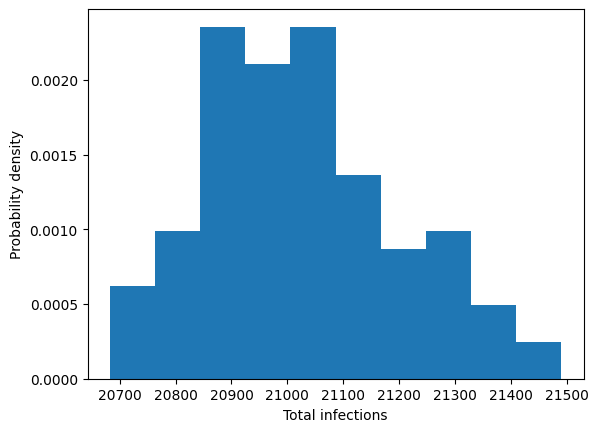

In [13]:
plt.hist(res['cum_infections'], density=True)

plt.xlabel('Total infections')
plt.ylabel('Probability density')

### Plotting time series

Time series plots can be obtained by accessing the dataframes associated with each seed, and then plotting quantities from those. For convenience, iterating over the `Samples` object will automatically iterate over all of the dataframes associated with each seed. For example:

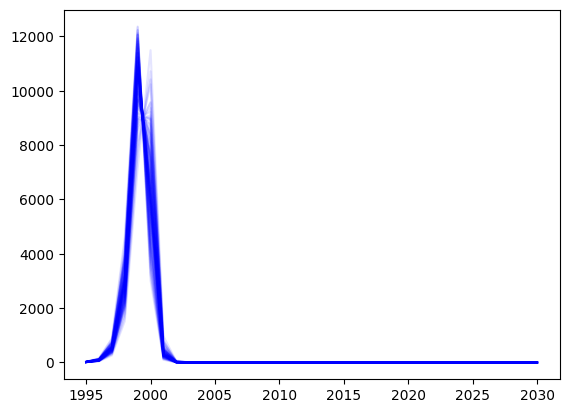

In [14]:
for df in res:
    plt.plot(df['sir.new_infections'], color='b', alpha=0.1)

### Other ways to access content

We have seen so far that we can use

- `res.summary` - retrieve dataframe of summary outputs
- `res[summary_column]` - retrieve a column of the summary dataframe
- `res[seed]` - retrieve the time series dataframe associated with one of the simulations
- `for df in res` - iterate over time series dataframes

Sometimes it is useful to have access to both the summary dictionary and the time series dataframe associated with a single sample. These can be accessed using the `get` method, which takes in a seed, and returns both outputs for that seed together:

In [15]:
res.get(0) # Retrieve both summary quantities and dataframes

(#0. 'p_death':        0.2
 #1. 'cum_infections': 20918.0
 #2. 'cum_deaths':     3383.0,
         n_alive  new_deaths  sir.n_susceptible  sir.n_infected  \
 t                                                                
 1995.0    10000           0               9983              17   
 1996.0    10000           0               9901              99   
 1997.0    10000           0               9356             644   
 1998.0    10000           0               6799            3200   
 1999.0     9997           3               1423            8570   
 2000.0     9994           3                 57            9916   
 2001.0     9959          35                  1            9807   
 2002.0     9783         176                  0            9039   
 2003.0     9298         485                  0            7002   
 2004.0     8327         971                  0            3840   
 2005.0     7330         997                  0            1261   
 2006.0     6805         525            

In the same way that it is possible to index the `Samples` object directly in order to retrieve columns from the summary dataframe, it is also possible to directly index the `Samples` object to get a column of the time series dataframe. In this case, pass a tuple of items to the `Samples` object, where the first item is the seed, and the second is a column from the time series dataframe. For example:

In [16]:
res[0,'sir.n_infected'] # Equivalent to `res[0]['sir.n_infected']`

t
1995.0      17
1996.0      99
1997.0     644
1998.0    3200
1999.0    8570
2000.0    9916
2001.0    9807
2002.0    9039
2003.0    7002
2004.0    3840
2005.0    1261
2006.0     228
2007.0      23
2008.0       0
2009.0       0
2010.0       0
2011.0       0
2012.0       0
2013.0       0
2014.0       0
2015.0       0
2016.0       0
2017.0       0
2018.0       0
2019.0       0
2020.0       0
2021.0       0
2022.0       0
2023.0       0
2024.0       0
2025.0       0
2026.0       0
2027.0       0
2028.0       0
2029.0       0
2030.0       0
Name: sir.n_infected, dtype: int64

### Filtering results

The `.seeds` attribute contains a listing of seeds, which can be helpful for iteration

In [17]:
res.seeds

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

The seeds are drawn from the summary dataframe, which defines which seeds are accessible via the `Samples` object. Therefore, you can drop rows from the summary dataframe to filter the results. For example, suppose we only wanted to analyze simulations with over 21000 deaths. We could retrieve a copy of the summary dataframe that only contains matching simulations

In [18]:
res.summary.loc[res['cum_infections']>21000]

,,cum_infections,cum_deaths
seed,p_death,,
1,0.2,21328,3459
2,0.2,21216,3435
4,0.2,21319,3414
5,0.2,21001,3377
7,0.2,21020,3515
12,0.2,21286,3442
16,0.2,21326,3481
18,0.2,21227,3361
19,0.2,21119,3454


We can then make a copy of the results and write the reduced summary dataframe back to that object

In [19]:
res2 = res.copy()
res2.summary = res.summary.loc[res['cum_infections']>21000]

<div class="alert alert-warning">    
Unlike <code>sc.dcp()</code>, copying using the <code>.copy()</code> method only deep copies the summary dataframe. It does not duplicate the time series dataframes or the cache. For <code>Samples</code> objects, it is therefore generally preferable to use <code>.copy()</code>.
</div>


Now notice that there are fewer samples, and the seeds have been filtered

In [20]:
len(res)

100

In [21]:
len(res2)

53

In [22]:
res2.seeds

array([ 1,  2,  4,  5,  7, 12, 16, 18, 19, 22, 24, 25, 26, 27, 28, 31, 32,
       33, 36, 42, 44, 46, 47, 50, 51, 52, 53, 54, 57, 58, 61, 64, 66, 67,
       70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 88, 89, 92, 93, 94, 95, 97,
       98, 99], dtype=int64)

Text(0, 0.5, 'Probability density')

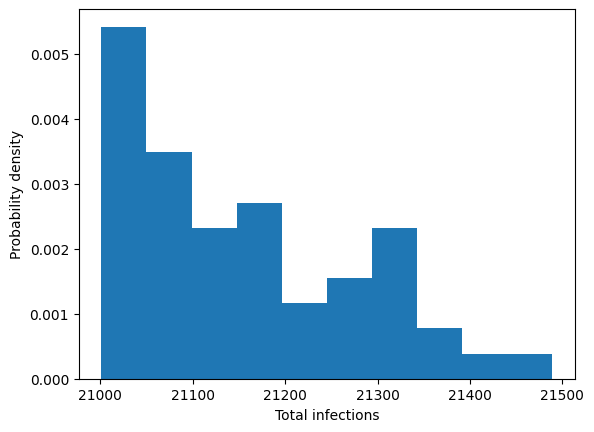

In [23]:
plt.hist(res2['cum_infections'], density=True)
plt.xlabel('Total infections')
plt.ylabel('Probability density')

### Applying functions and transformations

Sometimes it might be necessary to calculate quantities that are derived from the time series dataframes. These could be simple scalar values, such as totals or averages that had not been computed ahead of time, or extracting values from each simulation at a particular point in time. As an alternative to writing a loop that iterates over the seeds, the `.apply()` method takes in a function and maps it to every dataframe. This makes it quick to construct lists or arrays with scalar values extracted from the time series. For example, suppose we wanted to extract the peak number of people infected from each simulation:

In [24]:
peak_infections = lambda df: df['sir.n_infected'].max()
res.apply(peak_infections)

[9916,
 9871,
 9856,
 9921,
 9867,
 9906,
 9921,
 9915,
 9902,
 9885,
 9865,
 9889,
 9860,
 9883,
 9888,
 9882,
 9869,
 9892,
 9847,
 9876,
 9892,
 9901,
 9844,
 9897,
 9840,
 9864,
 9907,
 9862,
 9902,
 9915,
 9902,
 9903,
 9874,
 9879,
 9900,
 9905,
 9870,
 9912,
 9912,
 9895,
 9924,
 9918,
 9899,
 9888,
 9899,
 9905,
 9864,
 9898,
 9894,
 9925,
 9867,
 9911,
 9910,
 9906,
 9886,
 9911,
 9899,
 9839,
 9843,
 9859,
 9915,
 9883,
 9917,
 9889,
 9883,
 9910,
 9886,
 9887,
 9912,
 9886,
 9897,
 9883,
 9889,
 9913,
 9863,
 9891,
 9879,
 9895,
 9879,
 9885,
 9879,
 9888,
 9920,
 9902,
 9866,
 9898,
 9909,
 9901,
 9917,
 9909,
 9896,
 9909,
 9885,
 9895,
 9887,
 9908,
 9920,
 9912,
 9858,
 9884]

## Options when loading

There are two options available when loading that can change how the `Samples` class interacts with the file on disk:

- `memory_buffer` - copy the entire file into memory. This prevents the file from being locked on disk and allows scripts to be re-run and results regenerated while still running the analysis notebook. This defaults to `True` for convenience, but loading the entire file into memory can be problematic if the file is large (e.g., >1GB) in which case setting `memory_buffer=False` may be preferable
- `preload` - Populate the cache in one step. This facilitates interactive usage of the analysis notebook by making the runtime of analysis functions predictable (since all results will be retrieved from the cache) at the expense of a long initial load time



### Implementation details

If the file is loaded from a memory buffer, the `._zipfile` attribute will be populated. A helper property `.zipfile` is used to access the buffer, so if caching is not used, `.zipfile` returns the actual file on disk rather than the buffer

In [25]:
res = ss.Samples('results/0.2.zip', memory_buffer=True) # Copy the entire file into memory
print(res._zipfile)
print(res.zipfile)

<zipfile.ZipFile file=<_io.BytesIO object at 0x0000023319172890> mode='r'>
<zipfile.ZipFile file=<_io.BytesIO object at 0x0000023319172890> mode='r'>


In [26]:
res = ss.Samples('results/0.2.zip', memory_buffer=False) # Copy the entire file into memory
print(res._zipfile)
print(res.zipfile)

None
<zipfile.ZipFile filename='results/0.2.zip' mode='r'>


The dataframes associated with the individual dataframes are cached on access, so `pd.read_csv()` only needs to be called once. The cache starts out empty:

In [27]:
res._cache

{}

When a dataframe is accessed, it is automatically stored in the cache:

In [28]:
res[0]
res._cache.keys()

dict_keys([0])

This means that iterating through the dataframes the first time can be slow (but in general, iterating over all dataframes is avoided in favour of either only using summary outputs, or accessing a subset of the runs)

In [29]:
with sc.Timer():
    for df in res:
        continue

Elapsed time: 0.163 s


In [30]:
with sc.Timer():
    for df in res:
        continue

Elapsed time: 8.16 ms


The `preload` option populates the entire cache in advance:

In [31]:
res = ss.Samples('results/0.2.zip', preload=True)

In [32]:
with sc.Timer():
    for df in res:
        continue

Elapsed time: 10.5 ms


In [33]:
with sc.Timer():
    for df in res:
        continue

Elapsed time: 8.98 ms


Together, these options provide some flexibility in terms of memory and time demands to suit analyses at various different scales.

## Running scenarios

Suppose we wanted to compare a range of different `p_death` values and `initial` values (initial number of infections). We might define these runs as

In [34]:
initials = np.arange(1,4)
p_deaths = np.arange(0,1,0.25)

Recall that our `run_sim()` function had an argument for `p_death`. We can extend this to include the `initial` parameter too. We can actually generalize this further by passing the parameters as keyword arguments to avoid needing to hard-code all of them. Note that we also need to add the `initial` value to the summary outputs:

In [35]:
def get_sim(seed, **kwargs):
    ppl = ss.People(10000)
    ppl.networks = ss.ndict(ss.RandomNetwork(n_contacts=ss.poisson(5)))
    sir = ss.SIR(pars=kwargs)
    sim = ss.Sim(people=ppl, diseases=sir, rand_seed=seed)
    sim.initialize(verbose=0)
    return sim
    
def run_sim(seed, **kwargs):
    sim = get_sim(seed, **kwargs)
    sim.run(verbose=0)
    df = sim.export_df()
    
    summary = {}
    summary['seed'] = sim.pars['rand_seed']
    summary['p_death']= sim.diseases[0].pars.p_death
    summary['initial']= sim.diseases[0].pars.initial
    summary['cum_infections'] = sum(sim.results.sir.new_infections)
    summary['cum_deaths'] = sum(sim.results.new_deaths)
    
    return df, summary

We can now easily run a set of scenarios with different values of `p_death` and save each one to a separate `Samples` object. Note that when we create the `Samples` objects now, we also want to specify that `'initial'` is one of the identifiers for the scenarios:

In [36]:
# Clear the existing results
for file_path in resultsdir.glob('*'):
    file_path.unlink()

In [37]:
# Run the sweep over initial and p_death
n = 100
seeds = np.arange(n)
for initial in initials:
    for p_death in p_deaths:
        outputs = [run_sim(seed, initial=initial, p_death=p_death) for seed in seeds]
        ss.Samples.new(resultsdir, outputs, ["p_death","initial"])

The results folder now contains a collection of saved `Samples` objects. Notice how the automatically selected file names now contain both the `p_death` value and the `initial` value, because they were both specified as identifiers. We can load one of these objects in to see how these identifiers are stored and accessed inside the `Samples` class:

In [38]:
list(resultsdir.iterdir())

[WindowsPath('results/0.0-1.zip'),
 WindowsPath('results/0.0-2.zip'),
 WindowsPath('results/0.0-3.zip'),
 WindowsPath('results/0.25-1.zip'),
 WindowsPath('results/0.25-2.zip'),
 WindowsPath('results/0.25-3.zip'),
 WindowsPath('results/0.5-1.zip'),
 WindowsPath('results/0.5-2.zip'),
 WindowsPath('results/0.5-3.zip'),
 WindowsPath('results/0.75-1.zip'),
 WindowsPath('results/0.75-2.zip'),
 WindowsPath('results/0.75-3.zip')]

In [39]:
res = ss.Samples('results/0.25-2.zip')

The 'id' of a `Samples` object is a dictionary of the identifiers, which makes it easy to access the input parameters associated with a set of scenario runs:

In [40]:
res.id

{'p_death': 0.25, 'initial': 2}

The 'identifier' is a tuple of these values, which is suitable for use as a dictionary key. This can be useful for accumulating and comparing variables across scenarios

In [41]:
res.identifier

(0.25, 2)

### Loading multiple scenarios

We saw above that we now have a directory full of `.zip` files corresponding to the various scenario runs. These can be accessed using the `Dataset` class, which facilitates accessing multiple instances of `Samples`. We can pass the folder containing the results to the `Dataset` constructor to load them all:

In [42]:
results = ss.Dataset(resultsdir)
results

<Dataset:
	'p_death':[0.0, 0.25, 0.5, 0.75]
	'initial':[1, 2, 3]
>

The `.ids` attribute lists all of the values available across scenarios in the results folder:

In [43]:
results.ids

{'p_death': [0.0, 0.25, 0.5, 0.75], 'initial': [1, 2, 3]}

The individual results can be accessed by indexing the `Dataset` instance using the values of the identifiers. For example:

In [44]:
results[0.25,2]

<Samples 0.25-2, 100 seeds>

This indexing operation is sensitive to the order in which the identifiers are specified. The `.get()` method allows you to specify them as key-value pairs

In [45]:
results.get(initial=2, p_death=0.25)

<Samples 0.25-2, 100 seeds>

Iterating over the `Dataset` will iterate over the `Samples` instances contained within it

In [46]:
for res in results:
    print(res)

<Samples 0.0-1, 100 seeds>
<Samples 0.0-2, 100 seeds>
<Samples 0.0-3, 100 seeds>
<Samples 0.25-1, 100 seeds>
<Samples 0.25-2, 100 seeds>
<Samples 0.25-3, 100 seeds>
<Samples 0.5-1, 100 seeds>
<Samples 0.5-2, 100 seeds>
<Samples 0.5-3, 100 seeds>
<Samples 0.75-1, 100 seeds>
<Samples 0.75-2, 100 seeds>
<Samples 0.75-3, 100 seeds>


This can be used to extract and compare values across scenarios. For example, we could consider the use case of making a plot that compares total deaths across scenarios:

Text(0, 0.5, 'Scenario')

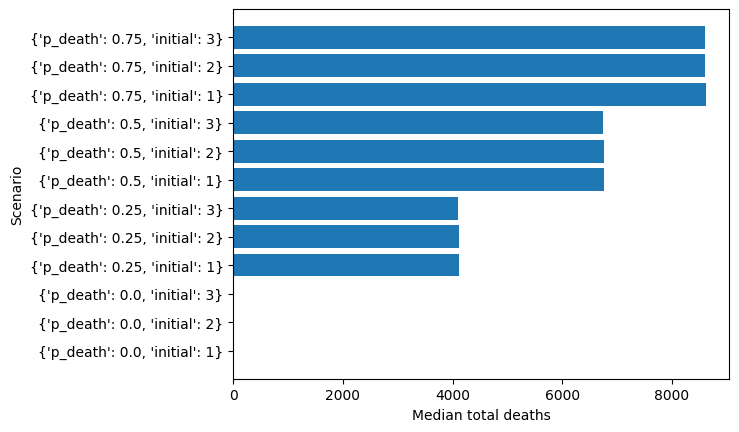

In [47]:
labels = []
y = []
yerr = []

for res in results:
    labels.append(res.id)
    y.append(res['cum_deaths'].median())

plt.barh(np.arange(len(results)),y, tick_label=labels)
plt.xlabel('Median total deaths');
plt.ylabel('Scenario')

### Filtering scenarios

Often plots need to be generated for a subset of scenarios e.g., for sensitivity analysis or to otherwise compare specific scenarios. `Dataset.filter` returns a new `Dataset` containing a subset of the results:

In [48]:
for res in results.filter(initial=2):
    print(res)

<Samples 0.0-2, 100 seeds>
<Samples 0.25-2, 100 seeds>
<Samples 0.5-2, 100 seeds>
<Samples 0.75-2, 100 seeds>


In [49]:
for res in results.filter(p_death=0.25):
    print(res)

<Samples 0.25-1, 100 seeds>
<Samples 0.25-2, 100 seeds>
<Samples 0.25-3, 100 seeds>


This is also a quick and efficient operation, so you can easily embed filtering commands inside the analysis to select subsets of the scenarios for plotting and other output generation. For instance:

Text(0, 0.5, 'New deaths')

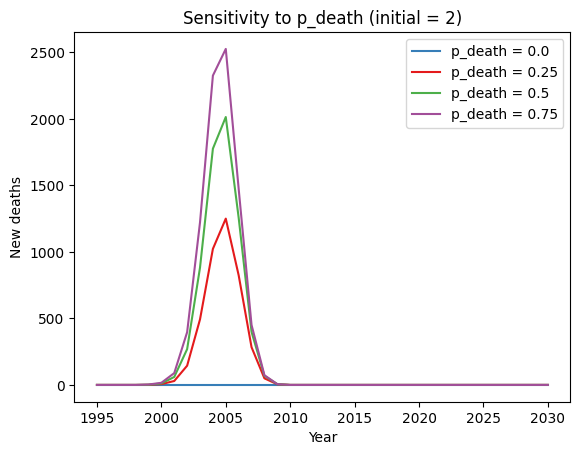

In [50]:
for res, color in zip(results.filter(initial=2), sc.gridcolors(4)):
    plt.plot(res[0].index, np.median([df['new_deaths'] for df in res], axis=0), color=color, label=f'p_death = {res.id["p_death"]}')
plt.legend()
plt.title('Sensitivity to p_death (initial = 2)')
plt.xlabel('Year')
plt.ylabel('New deaths')

Text(0, 0.5, 'New deaths')

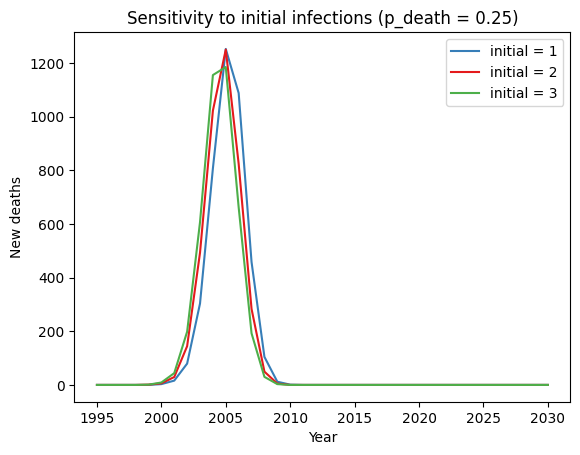

In [51]:
for res, color in zip(results.filter(p_death=0.25), sc.gridcolors(3)):
    plt.plot(res[0].index, np.median([df['new_deaths'] for df in res], axis=0), color=color, label=f'initial = {res.id["initial"]}')
plt.legend()
plt.title('Sensitivity to initial infections (p_death = 0.25)')
plt.xlabel('Year')
plt.ylabel('New deaths')